<a href="https://colab.research.google.com/github/catastropiyush/snowflake_automaton/blob/master/snowflake_automaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

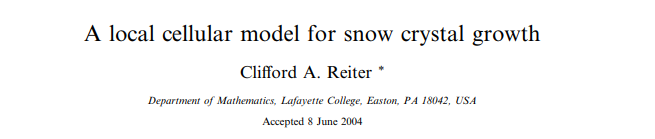

https://patarnott.com/pdf/SnowCrystalGrowth.pdf

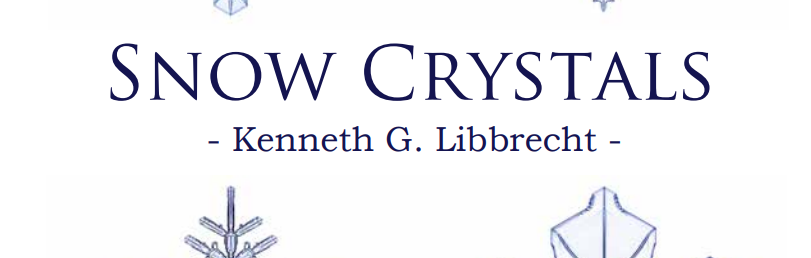

https://arxiv.org/pdf/1910.06389

In [1]:
# genearte a snowflake automaton in python

# imports
import numpy as np
import matplotlib.pyplot as plt
import os

"""
The grid is hexagonal, we make a 2d square array (n x n), and imagine
that each even index subarray of pixels is displaced to the left by half a pixel.
"""

# initializes the grid
def init_grid(beta,n=101):
    # n is the size of the grid
    grid = np.ones((n,n)) * beta
    # assume n is odd, fill middle cell with value 1
    mid = int((n-1)/2)
    grid[mid][mid] = 1 # this is the seed / mineral around which the snowflake forms

    return grid

# plot the grid
def plot_grid(grid,saveas=None,show=False):
#     normalized = grid / max(grid.flatten())
    # invert the color
    n = grid.shape[0]
    max_val = max(grid.flatten())
    inverted_grid = np.zeros((n,n))
    for i,row in enumerate(grid):
        for j,element in enumerate(row):
            inverted_grid[i][j] = max_val - element

    # plot it
    plt.figure(figsize=(8,8))
    plt.imshow(inverted_grid, cmap='Greys', interpolation='nearest')
    #plt.colorbar()
    plt.title("display of density")

    # save the figure
    if saveas:
        plt.savefig(saveas)
    if show: # display the figure
        plt.show(block=True) # in jupyter notebook set block=False

# set the max value threshold to be 1, when a pixel is 1 it is solid
def to_snowflake(grid):
    n = grid.shape[0]
    snowflake_grid = np.zeros((n,n))
    for i,row in enumerate(grid):
        for j,element in enumerate(row):
            if element >= 1: snowflake_grid[i][j] = 1
    return snowflake_grid

# helper for update grid, each (humid) gas cell becomes the average of it's neighbors
def average(grid,alpha):
    n = grid.shape[0]
    averaged_grid = np.zeros((n,n))
    # optimization: just convolve with a filter instead of this slow nested for loop
    for i,row in enumerate(grid):
        for j,element in enumerate(row):
            averaged_grid[i][j] += (1-alpha*0.5)*element

            averaged_grid[(i+1)%n][j] += alpha/12*element
            averaged_grid[i][(j-1)%n] += alpha/12*element
            averaged_grid[i][(j+1)%n] += alpha/12*element
            averaged_grid[(i-1)%n][j%n] += alpha/12*element

            if i%2==0:# if the row is even index it's to the left
                averaged_grid[(i+1)%n][(j-1)%n] += alpha/12*element
                averaged_grid[(i-1)%n][(j-1)%n] += alpha/12*element

            else:
                averaged_grid[(i+1)%n][(j+1)%n] += alpha/12*element
                averaged_grid[(i-1)%n][(j+1)%n] += alpha/12*element
    return averaged_grid

# update the grid, this is the discrete update function / diff-eq
def timestep(grid,alpha,gamma):
    n = grid.shape[0]

    # find the receptive cubes
    grid_is_receptive = np.zeros((n,n))
    for i,row in enumerate(grid):
        for j,element in enumerate(row):
            if element >= 1:
                grid_is_receptive[i][j] = 1
                grid_is_receptive[(i+1)%n][j] = 1
                grid_is_receptive[(i-1)%n][j] = 1
                grid_is_receptive[i][(j-1)%n] = 1
                grid_is_receptive[i][(j+1)%n] = 1
                if i%2==0:
                    grid_is_receptive[(i+1)%n][(j-1)%n] = 1
                    grid_is_receptive[(i-1)%n][(j-1)%n] = 1
                else:
                    grid_is_receptive[(i+1)%n][(j+1)%n] = 1
                    grid_is_receptive[(i-1)%n][(j+1)%n] = 1

    # make receptive and non receptive grids
    grid_receptive = np.zeros((n,n)) # the receptive sites
    grid_non_receptive = np.zeros((n,n)) # the non receptive sites
    for i,row in enumerate(grid):
        for j,element in enumerate(row):
            if grid_is_receptive[i][j]==1:
                grid_receptive[i][j] = element + gamma
            else:
                grid_non_receptive[i][j] = element


    grid_non_receptive = average(grid_non_receptive,alpha)
    return grid_receptive + grid_non_receptive

# checks to see if snowflake is too big for the grid, if it is, returns True, if not it returns false
def snowflake_too_big(grid):
    n = grid.shape[0]
    mid = int((n-1)/2)
    one_ninth = int(n/9)
    if grid[mid][one_ninth] >= 1:
        return True
    return False

# makes the grid bigger by adding some padding
def pad(grid,beta,pad_size=20):
    n = grid.shape[0]
    bigger_grid = np.ones((n+2*pad_size,n+2*pad_size))*beta
    for i in range(n):
        for j in range(n):
            bigger_grid[i+pad_size][j+pad_size] = grid[i][j]
    return bigger_grid

def make_snowflake_pngs_for_gif(alpha,beta,gamma,iterations,n):
    # make a new directory
    dir_name = "snowflake_pngs_alpha={}_beta={}_gamma={}".format(alpha,beta,gamma)
    os.mkdir(dir_name)

    grid = init_grid(beta,n) # initiate a seedling snowflake
    for i in range(iterations):
        grid = timestep(grid,alpha,gamma)

        if i % 50 == 0: # every 50th iteration, save an image of the snow-flake
            # chekc if the snowflake is too big for the grid, if so stop the loop
            if snowflake_too_big(grid):
                break

            # save the figure
            n = grid.shape[0]
            saveas = "{}/snowflake_alpha={}_beta={}_gamma={}_iter={}_n={}.png".format(dir_name,alpha,beta,gamma,i,n)
            plot_grid(grid,saveas)
            np.save("{}/snowflake_alpha={}_beta={}_gamma={}_iter={}_n={}".format(dir_name,alpha,beta,gamma,i,n),grid)


    # once we're done, save and display the final state
    n = grid.shape[0]
    saveas = "snowflake_alpha={}_beta={}_gamma={}_iter={}_n={}.png".format(alpha,beta,gamma,i,n)
    plot_grid(grid,saveas)
    np.save("snowflake_alpha={}_beta={}_gamma={}_iter={}_n={}".format(alpha,beta,gamma,i,n),grid)
    return

<ipython-input-1-039b1b5b9807>:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,8))


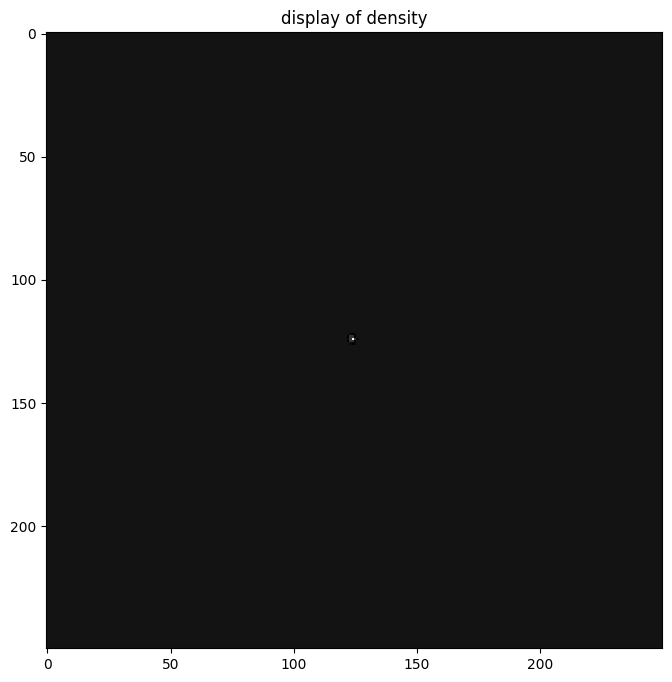

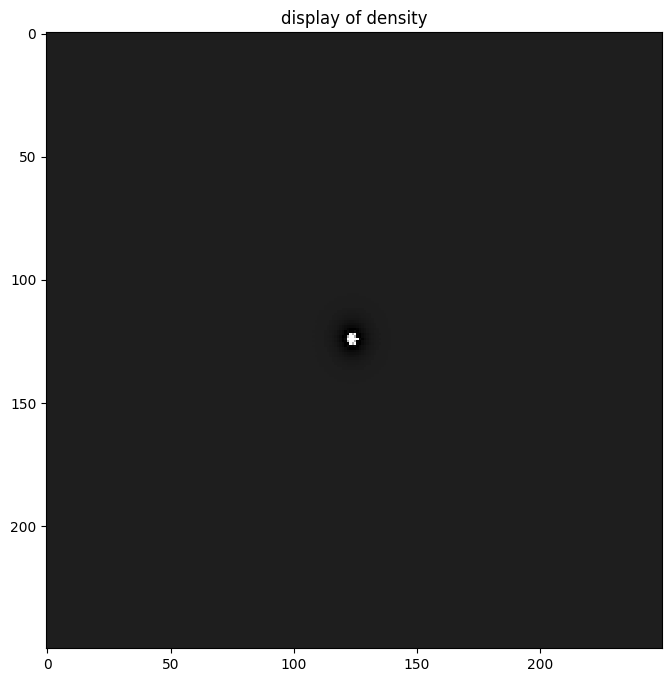

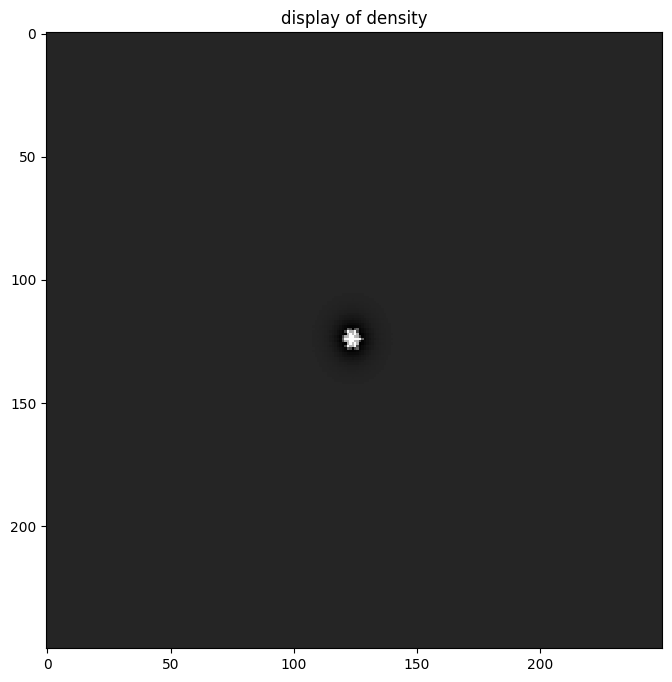

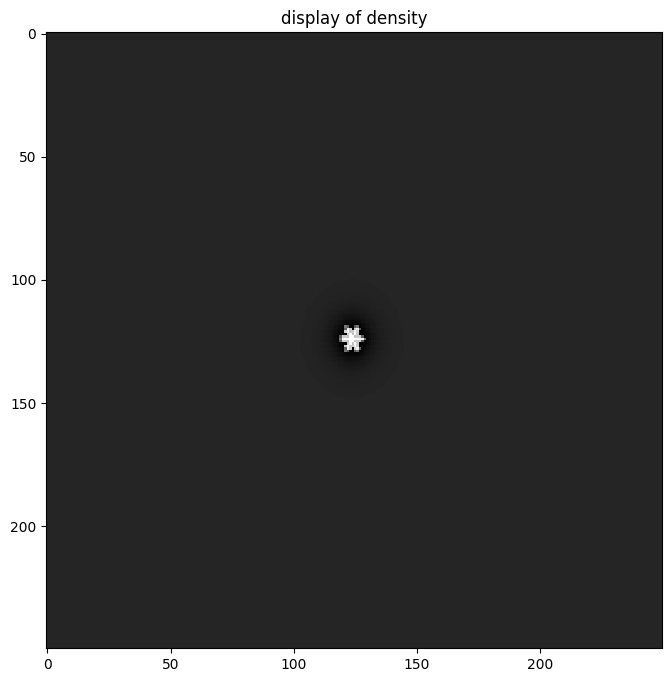

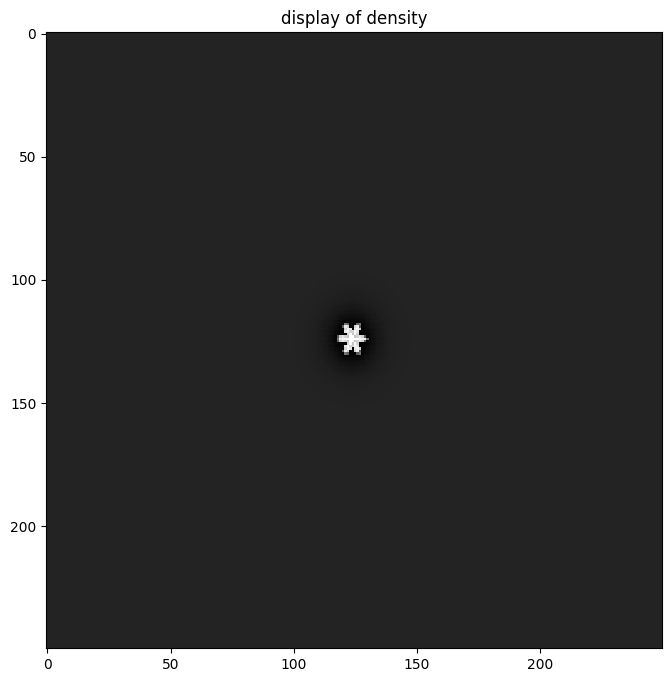

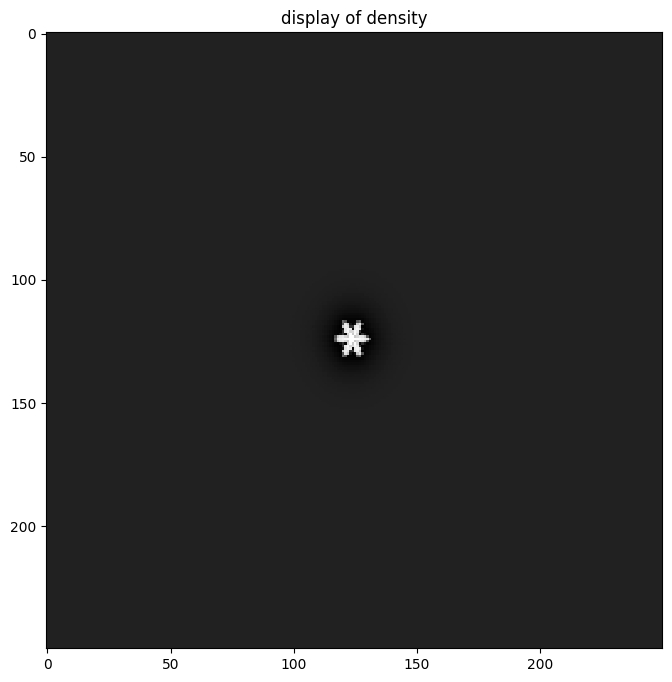

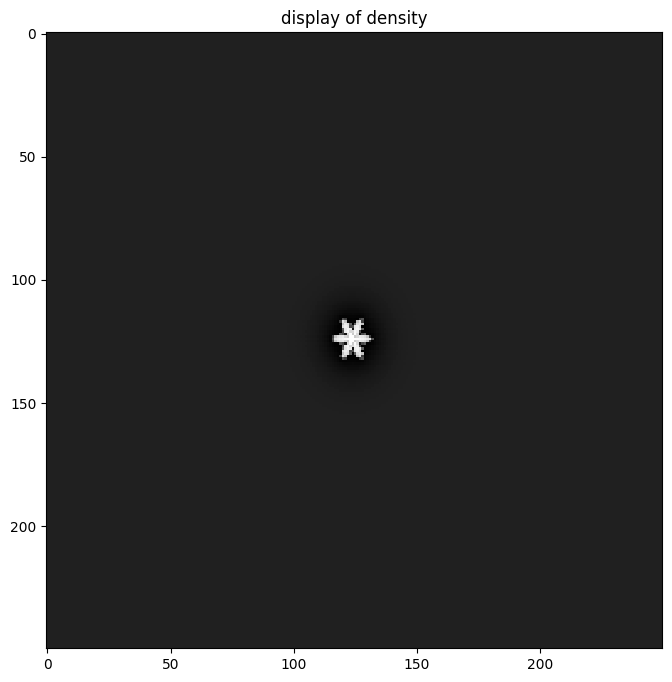

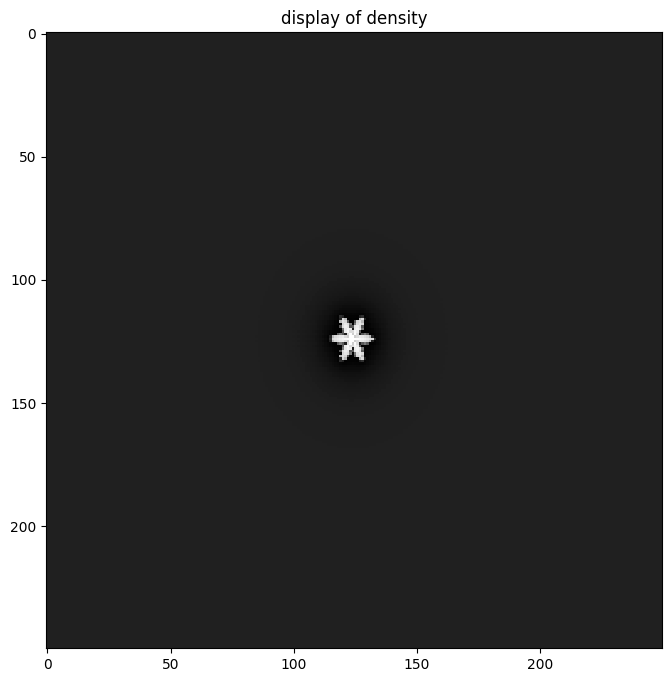

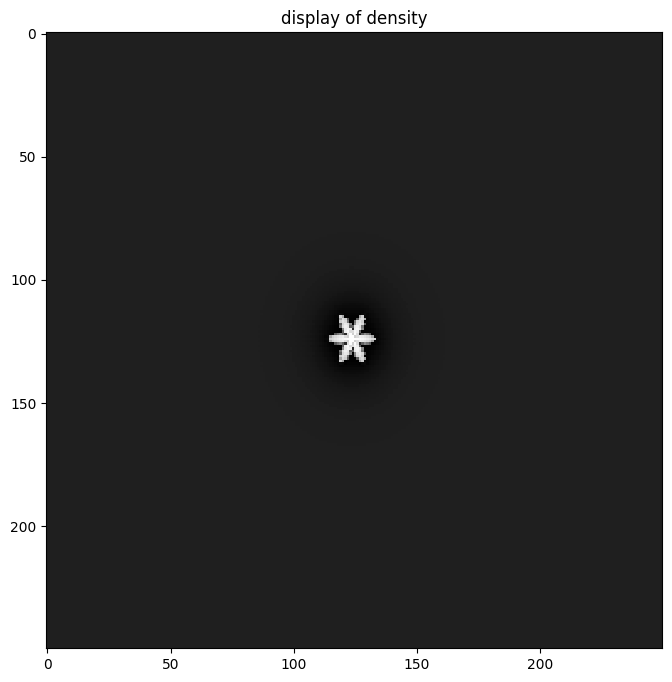

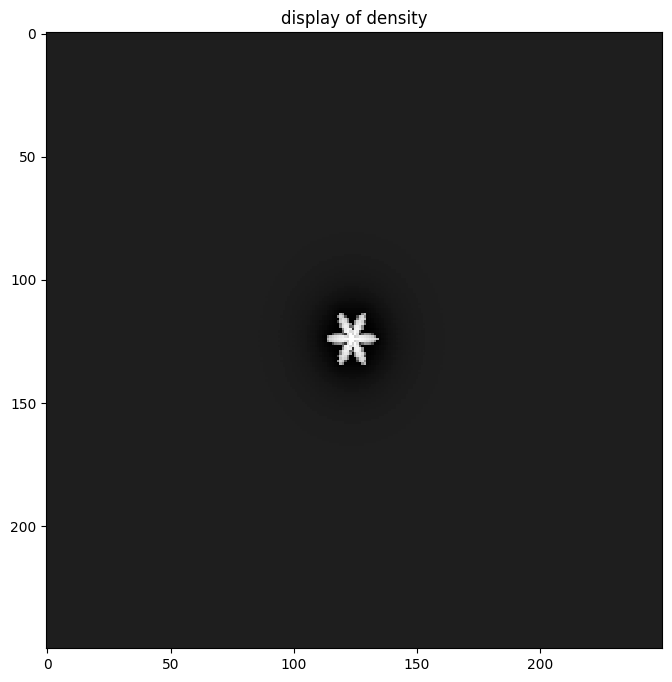

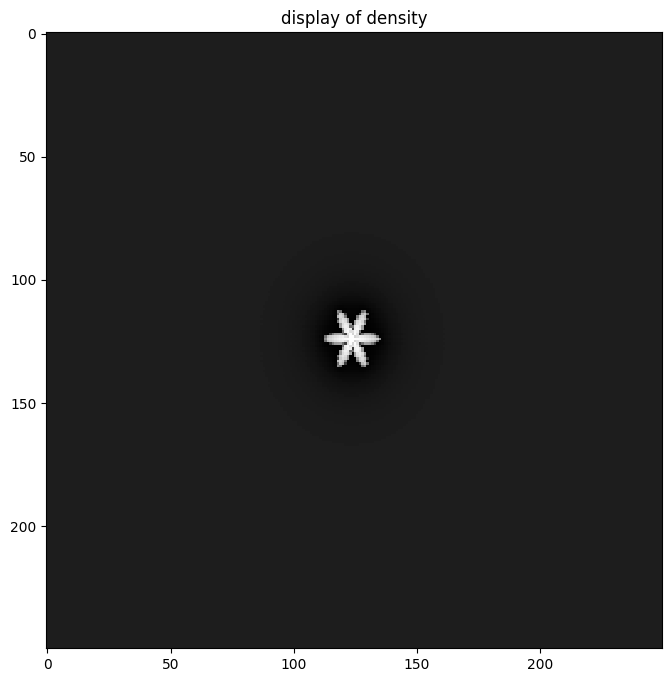

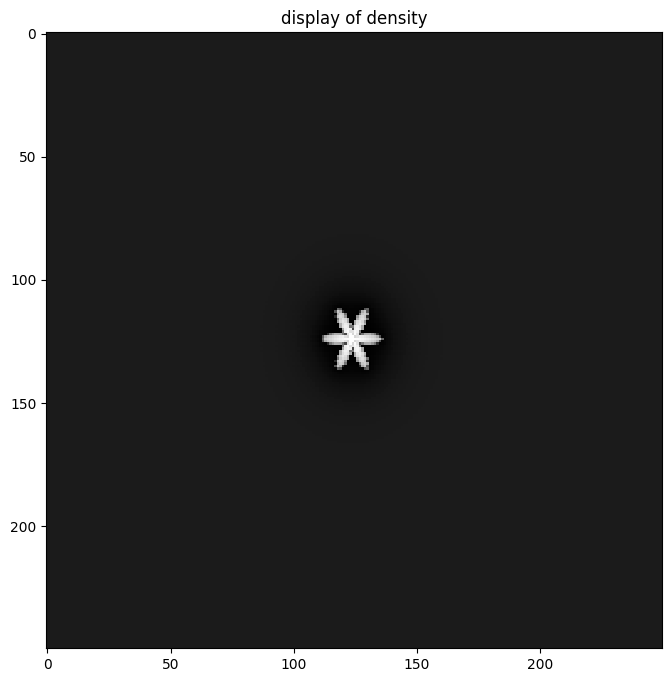

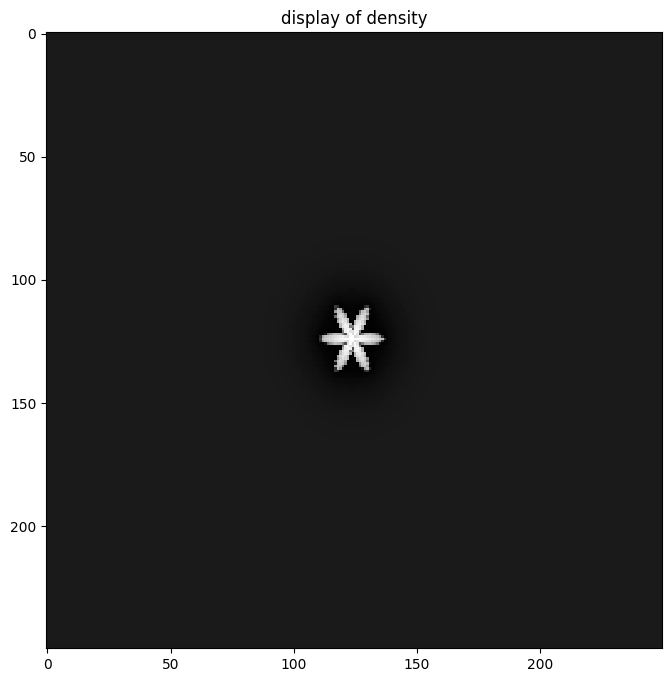

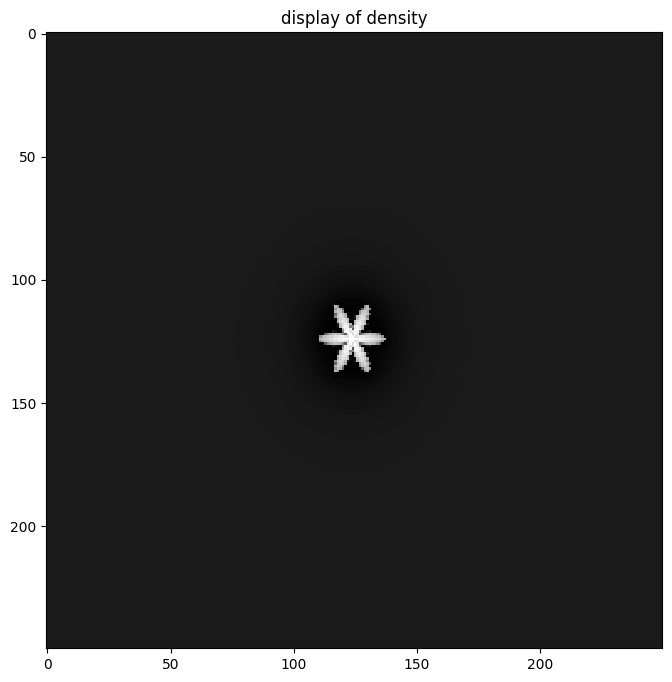

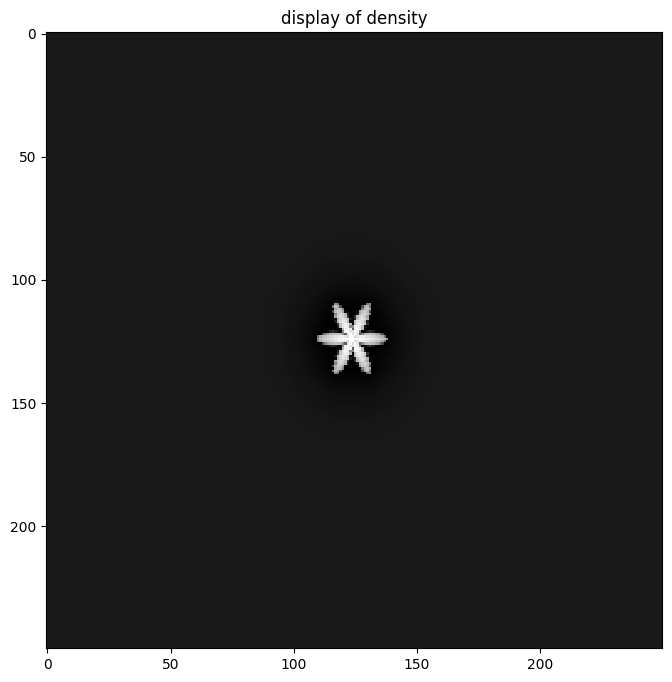

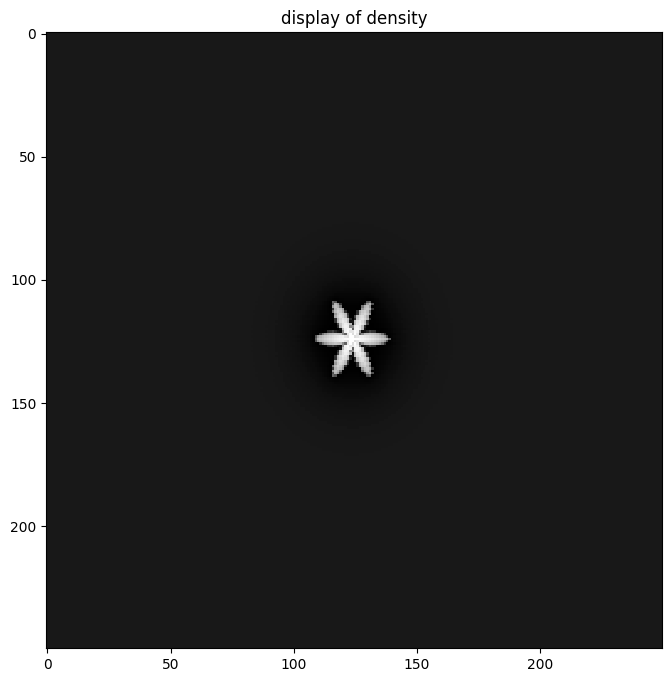

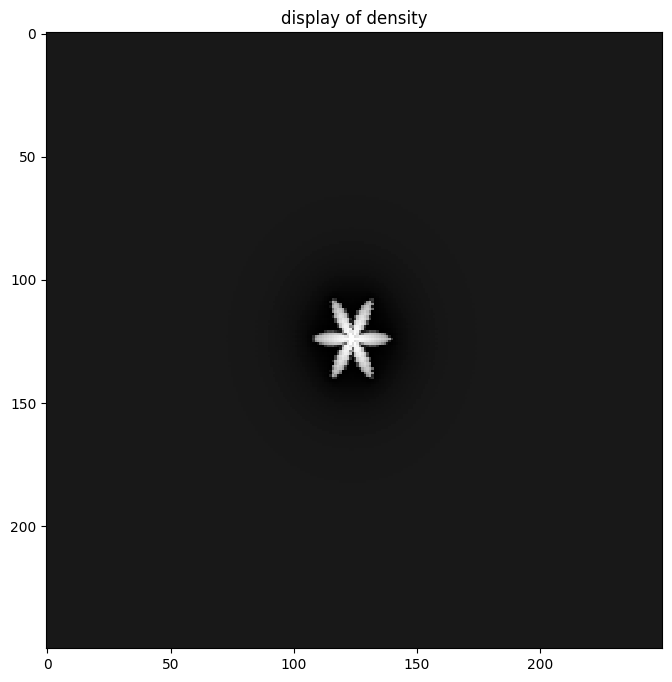

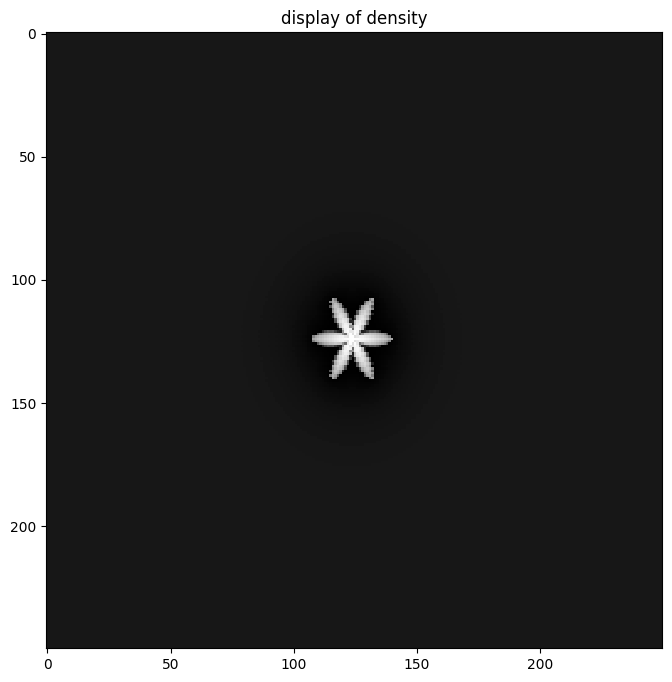

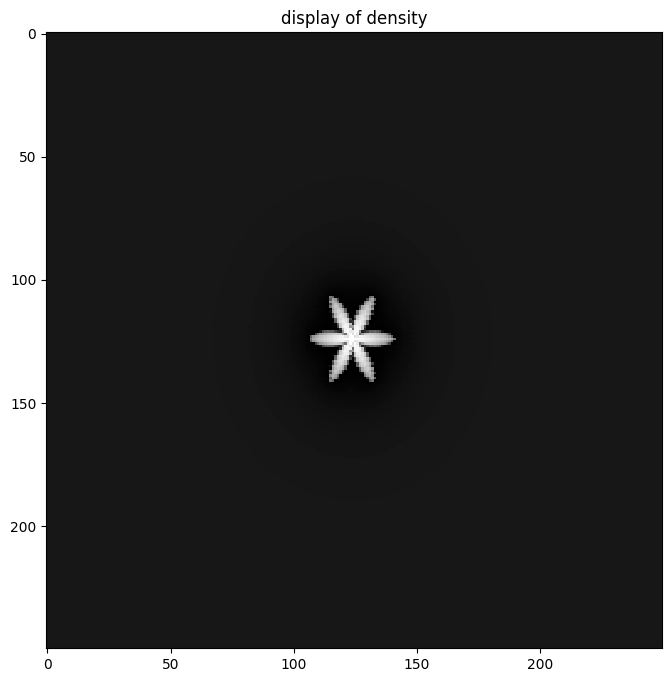

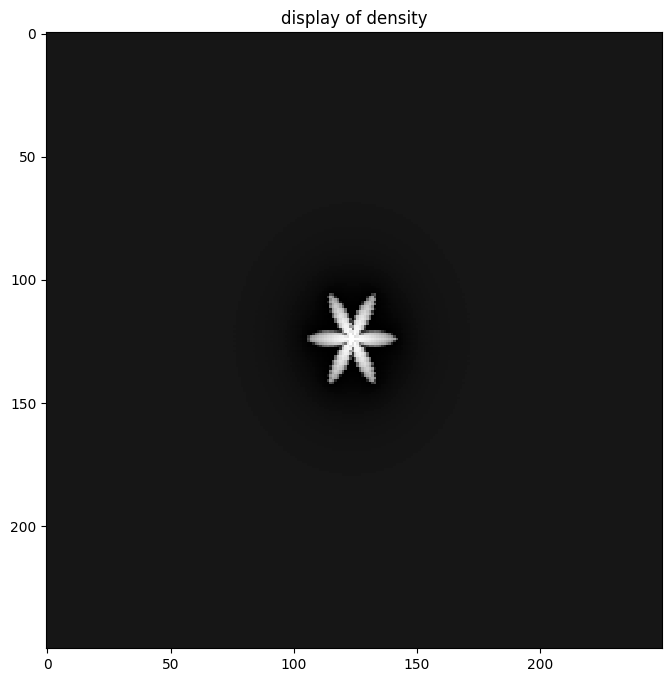

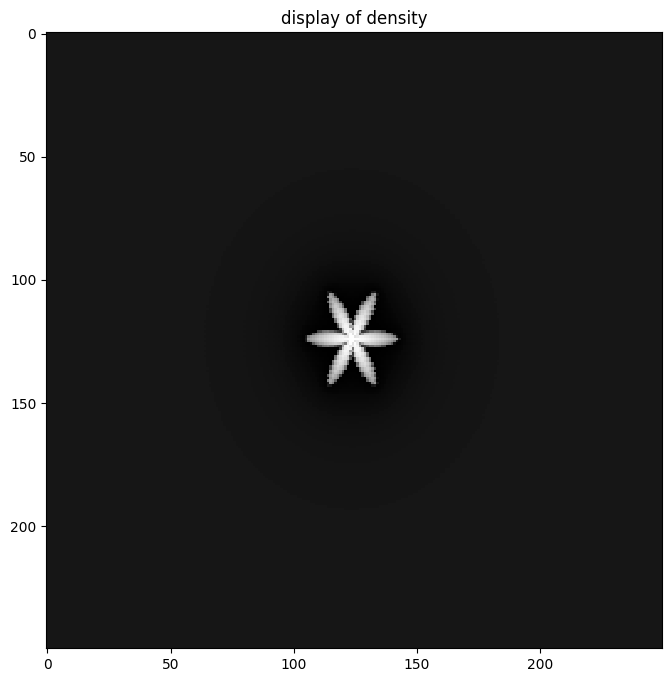

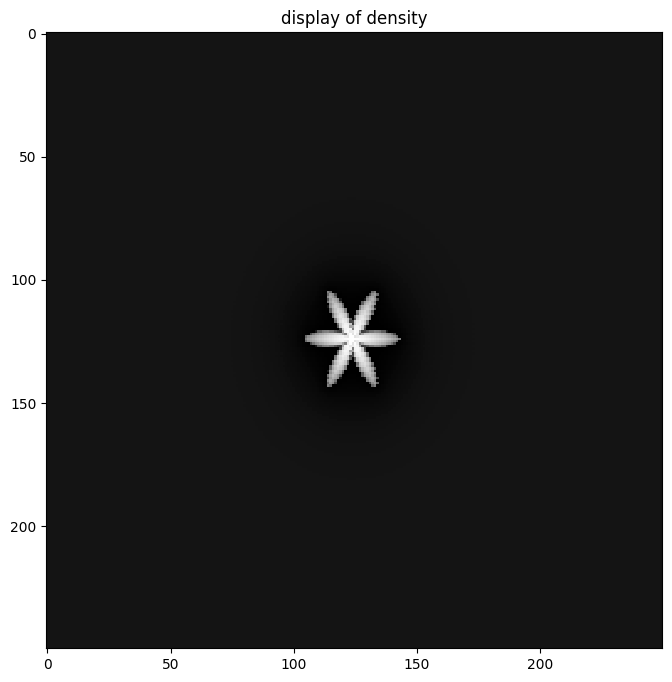

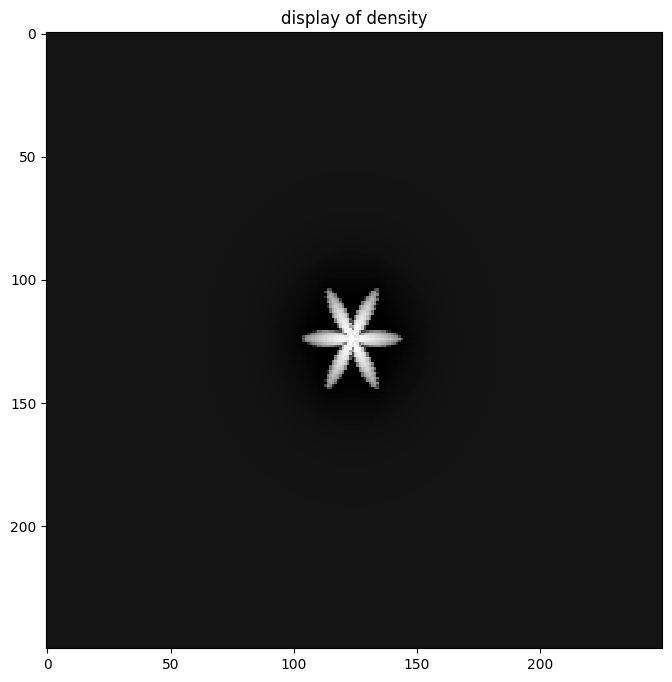

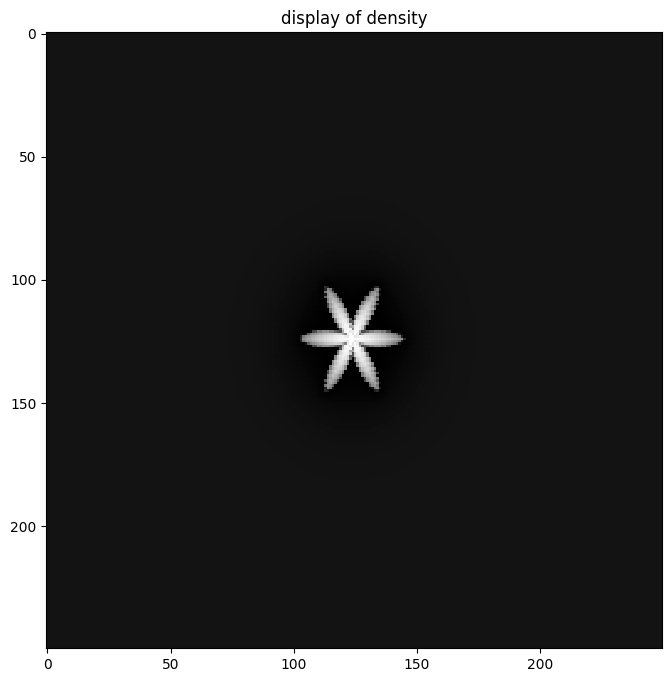

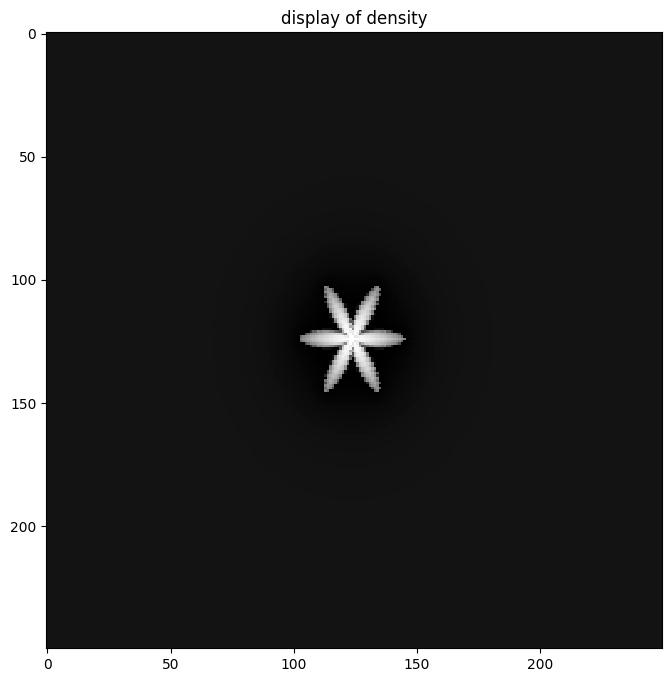

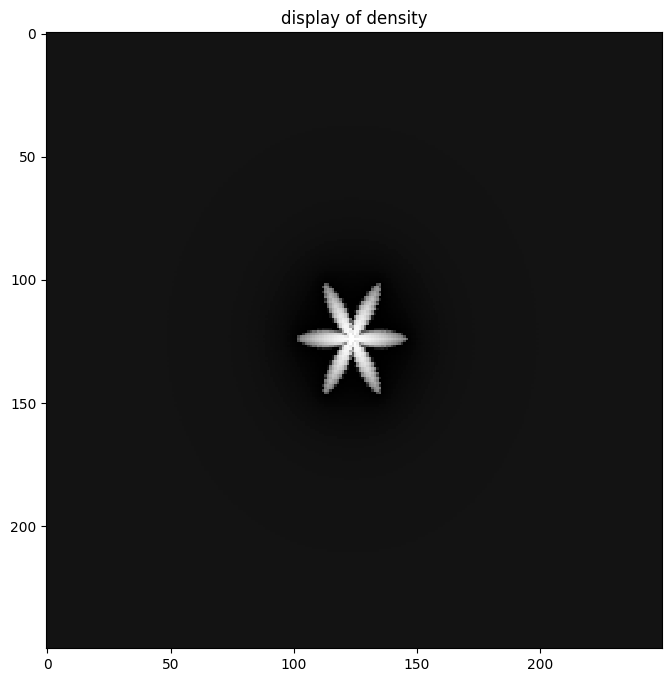

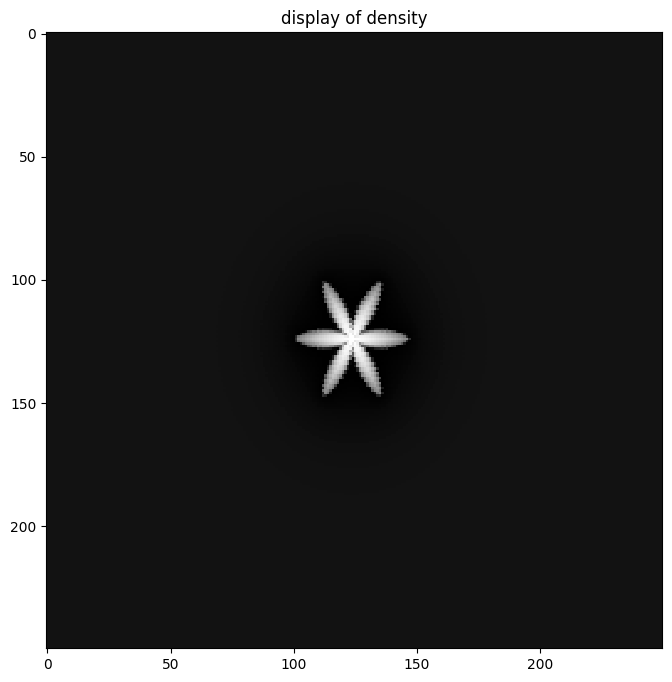

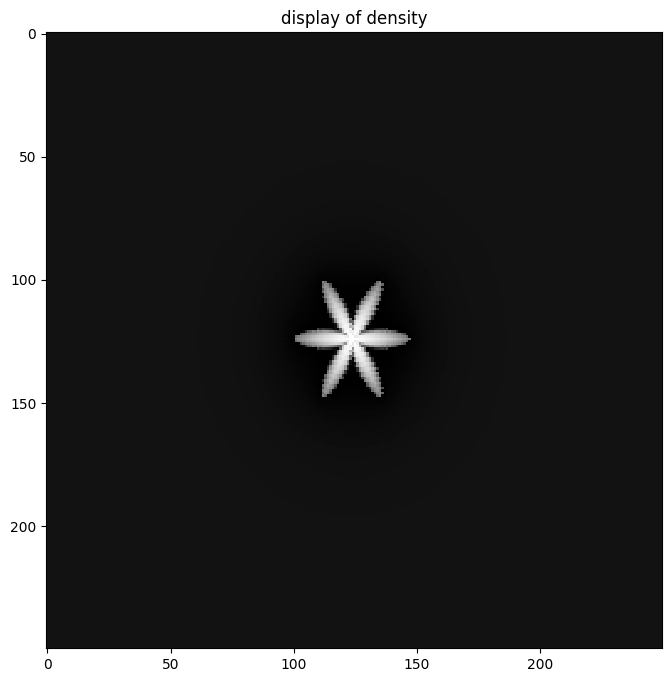

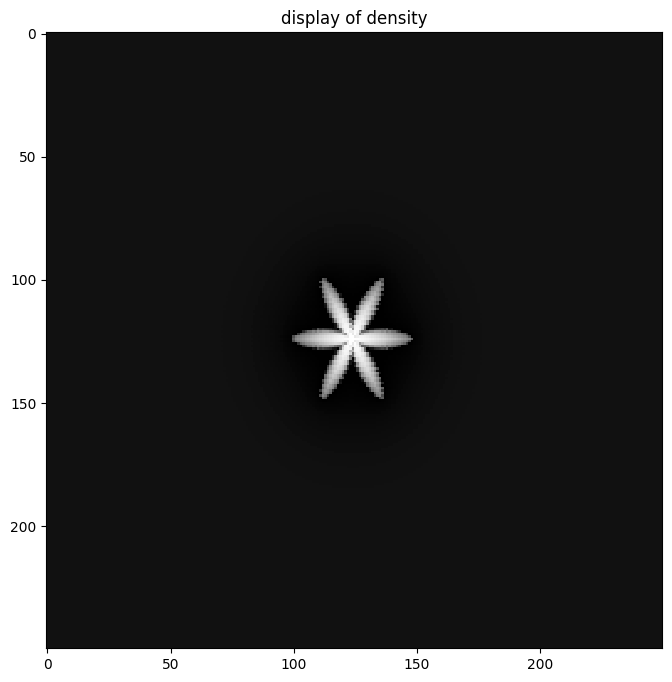

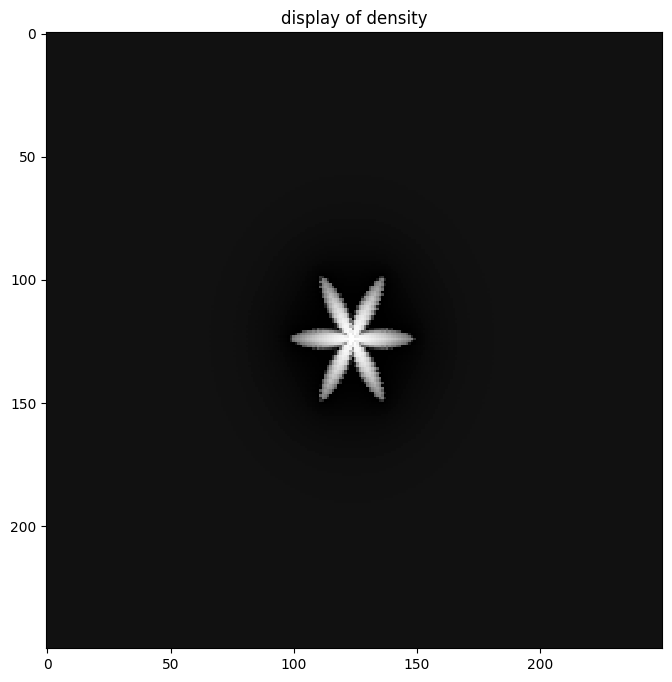

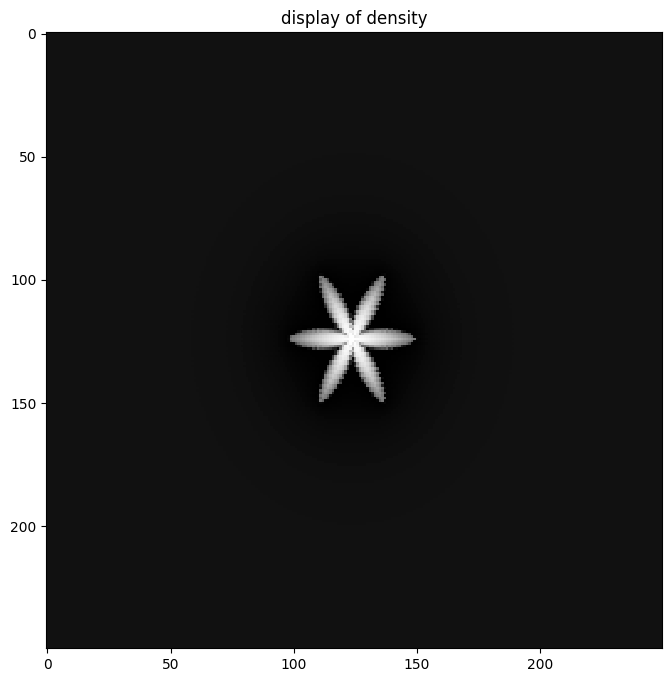

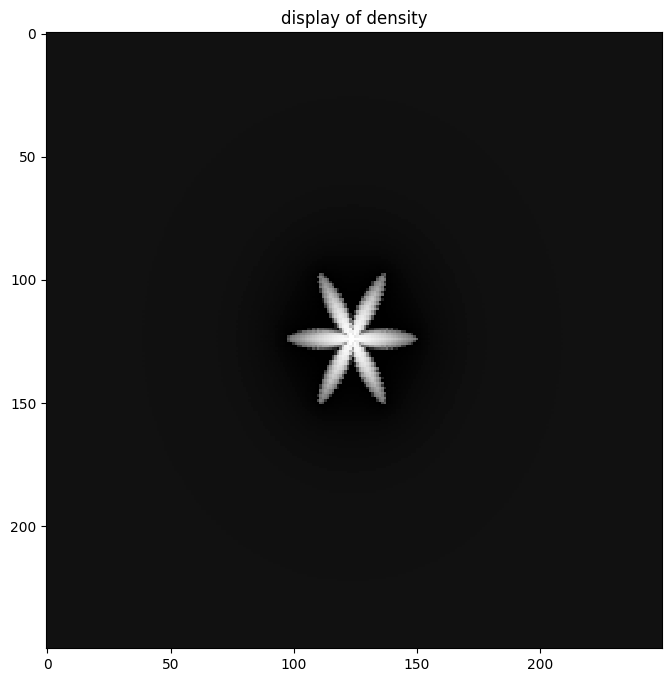

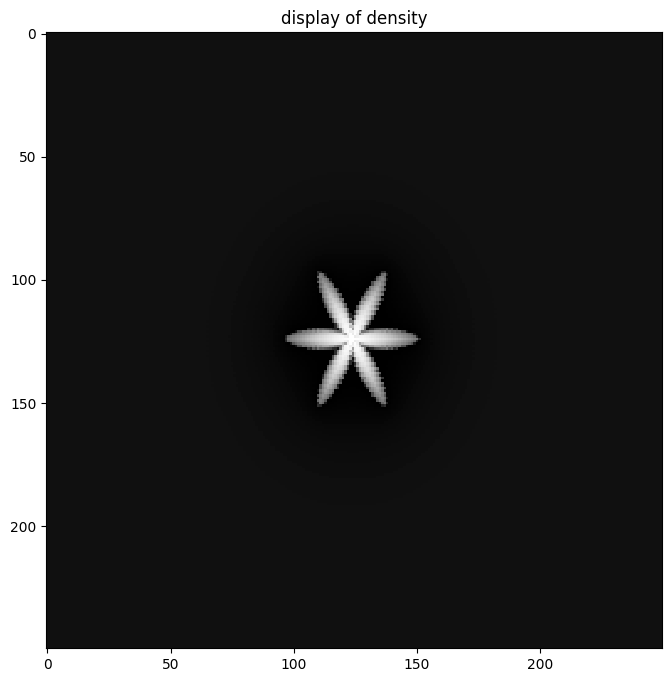

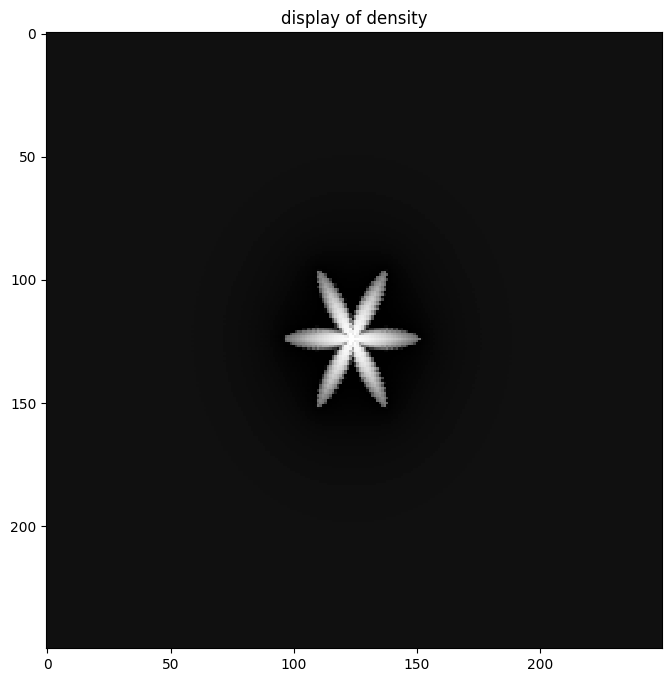

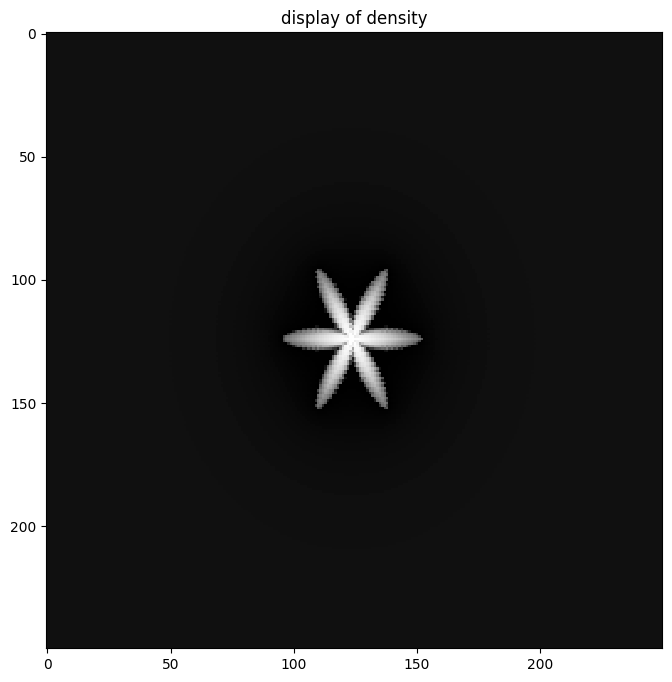

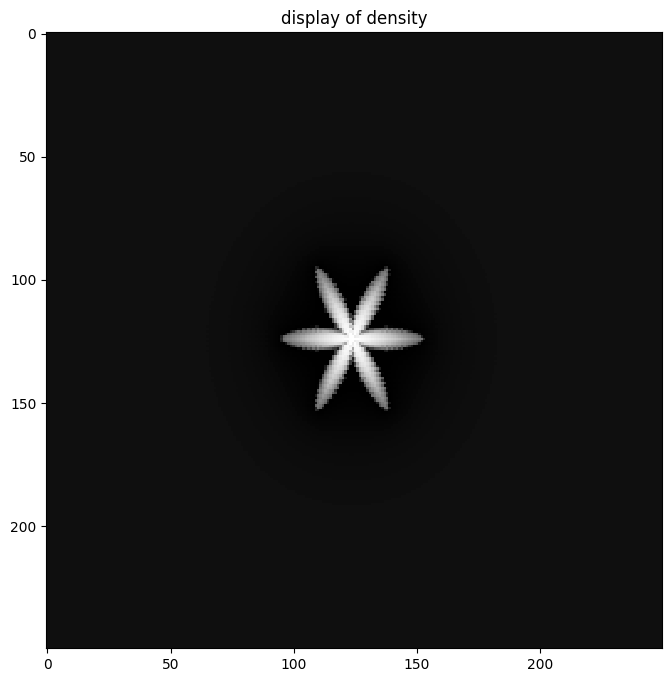

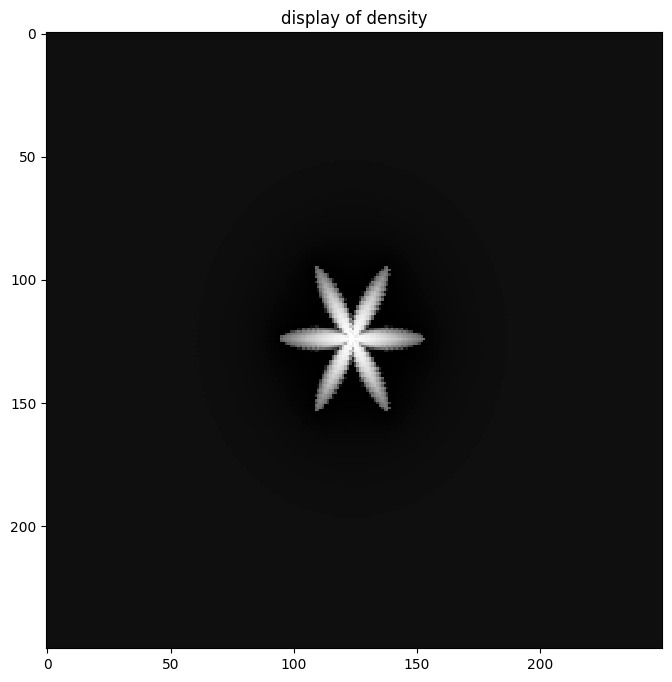

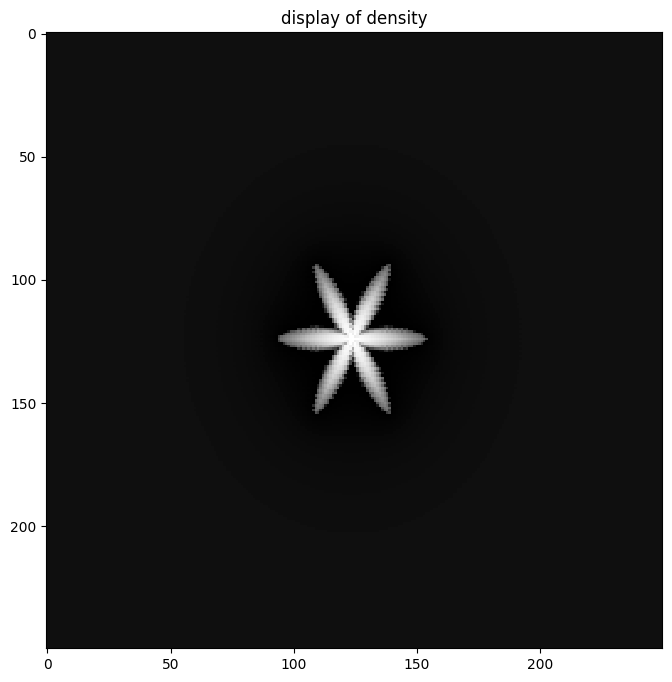

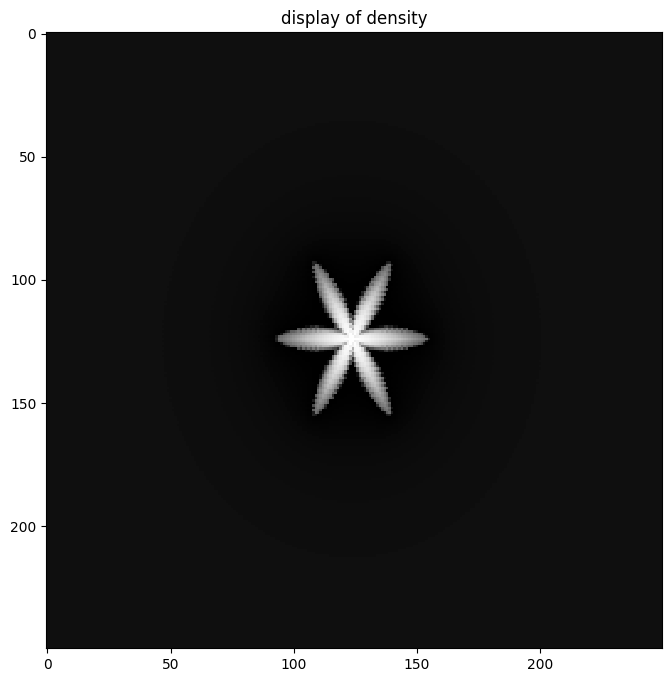

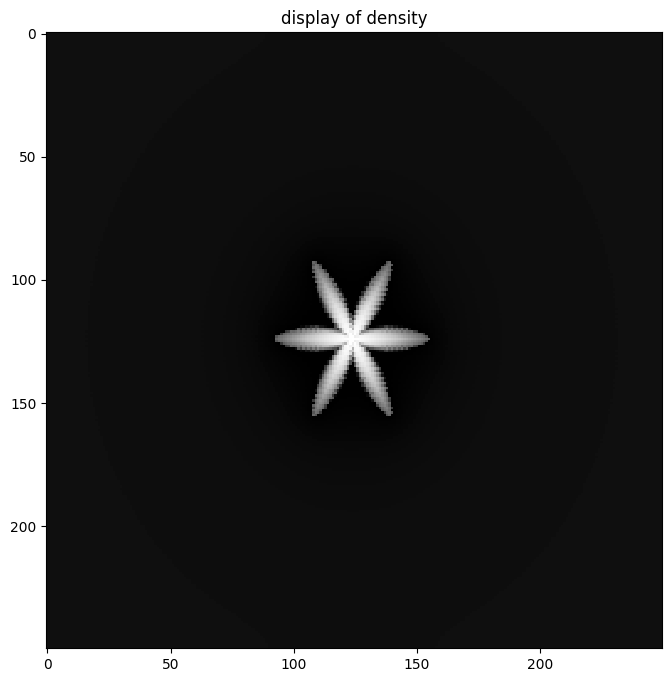

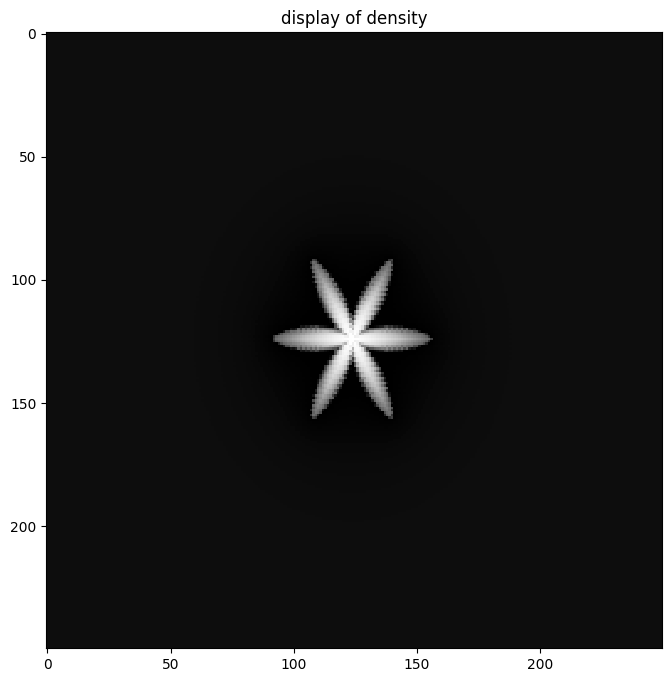

In [6]:
if __name__=="__main__":
    alpha = 2.44    # this is the diffusion constant
    beta = 0.15     # background level, initial water density in surrounding atmosphere
    gamma = 0.001   # accreation from outside to account for 3rd dimension
    max_iter = 2000 # maximum number of iterations for the simulation
    n = 250         # size of frame

    # grow the snowflake and generate pngs of it as it grows
    make_snowflake_pngs_for_gif(alpha,beta,gamma,max_iter,n)

In [7]:
import imageio
import os

def create_gif(image_folder, gif_name):
    images = []
    for filename in sorted(os.listdir(image_folder)):
        if filename.endswith(".png"):
            img_path = os.path.join(image_folder, filename)
            images.append(imageio.imread(img_path))
    imageio.mimsave(gif_name, images, fps=10)

# Example usage:
image_folder = "/content/snowflake_pngs_alpha=2.44_beta=0.15_gamma=0.001"
gif_name = "/content/snowflake.gif"  # Specify the desired output path
create_gif(image_folder, gif_name)

from google.colab import files
files.download(gif_name)

<ipython-input-7-10e69229f568>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_path))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

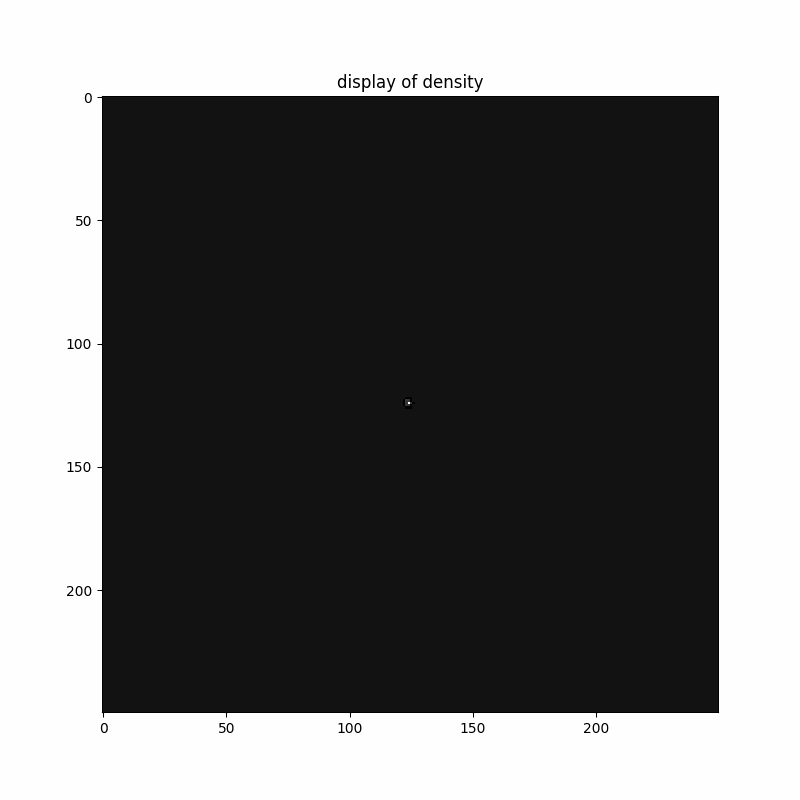

In [8]:
# prompt: display gif /content/snowflake.gif here
from IPython.display import Image, display
display(Image('/content/snowflake.gif'))